In [56]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import train_test_split

from Loader import Loader
import Constants as C
from Cuts import qlayerCut, maxDistMaxDoms, balloonCut

savedir = '../plots/CascadeTruth/'

In [26]:
# Load the 2014 burn sample
basesel = C.basesel
basesel += '&&(ImpLF_rchi2>80&&tlarge5[0]-tearly5[0] < 200)'
load = Loader(basesel)

# Add the truth branches
eb = ['eE','eZen','eVtxX','eVtxY','eVtxZ',
      'hE','hZen','hVtxX','hVtxY','hVtxZ',]
nue = load.getNuE(extraBranches=eb)

nue = balloonCut(nue)
nue = qlayerCut(nue,False,0.8)

# Add maxdist
nue['maxDist'] = maxDistMaxDoms(nue)

In [27]:
# Break into high and low energy (needed to make sure
# we get the same test and training size)
nue_he = nue[ np.log10(nue.PrimaryNeutrinoEnergy) >=6 ]
nue_le = nue[ np.log10(nue.PrimaryNeutrinoEnergy) < 6 ]

In [28]:
# Split the data into the test and training set. We want events that
# pass and fail the BDT cut, so we only want the training set
trainfrac = 0.5
nue_target = pd.Series(np.ones(len(nue_he),dtype=int),index=nue_he.index)
X_train, X_test, y_train, y_test = train_test_split(nue_he,
                                                    nue_target,
                                                    train_size=trainfrac,
                                                    random_state=194637)
X_test['wE2'] = X_test['wE2'] / (1-trainfrac)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
# Combine back together for the testing set
nue_test = pd.concat([nue_le, X_test])

In [30]:
# Load the classifier
clf = joblib.load('../models/bdt_hyperparamopt_cleaningupdate.pkl')

In [31]:
nue_test['scores'] = pd.Series(clf.decision_function(nue_test[C.bdt_features]),
                               index=nue_test.index)

2.68632452179


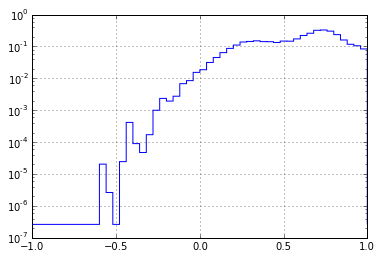

In [36]:
temp = nue_test[ np.log10(nue_test.PrimaryNeutrinoEnergy) >= 6]
print sum( temp[ temp.scores > 0.5 ].wE2 ) * 365/34.7
temp.scores.hist(weights=temp.wE2.as_matrix()*365/34.7,bins=50,range=(-1,1),
                histtype='step',log=True)

In [41]:
# Separate into pass and fail events
nue_p = nue_test[ nue_test.scores > 0.5 ]
nue_f = nue_test[ nue_test.scores <= 0.5 ]

In [74]:
info = {'data': [nue_p, nue_f],
        'names': [r'Astro. $\nu_{e}$ Pass bdt',
                  r'Astro. $\nu_{e}$ Fail bdt'],
        'c' : ['b','r'],
        'snames' : ['passbdt','failbdt']
       }

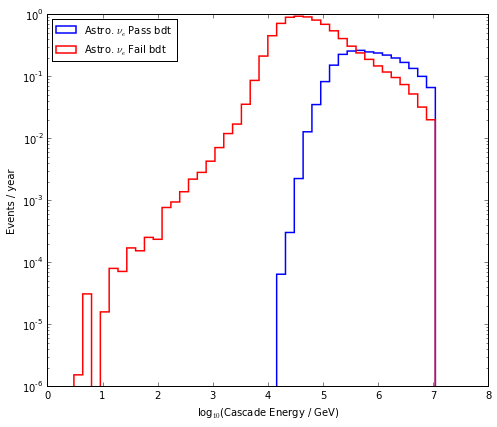

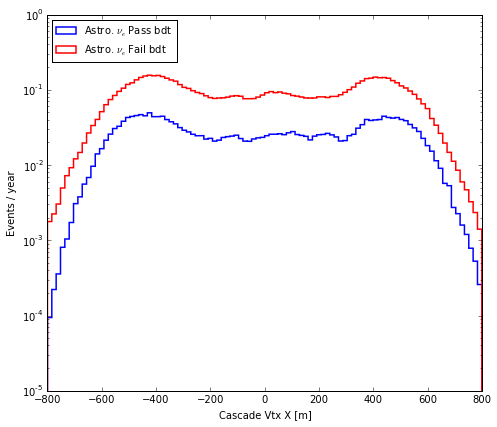

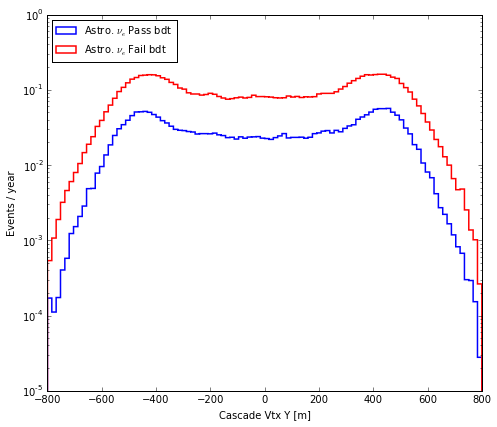

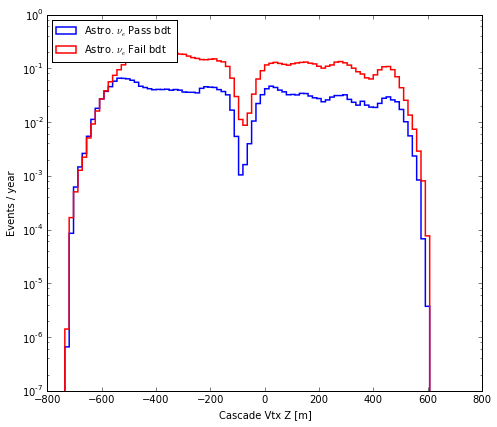

In [61]:
# Ok Let's plot the true cascade energy and the vertex position
# For events that pass and fail the reconstruction

sf = 365/34.7

# Energy
fig, ax = plt.subplots(ncols=1,figsize=(7,6))
for i in range(len(info['data'])):
    dt   = info['data'][i]
    c    = info['c'][i]
    name = info['names'][i]
    
    plt.hist(np.log10(dt.eE+dt.hE).as_matrix(),
             weights = dt.wE2.as_matrix() * sf,
             bins = 50,
             range=(0,8),
             color = c,
             lw = 1.5,
             histtype='step',
             label=name)
    
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(Cascade Energy / GeV)')
plt.ylabel('Events / year')
plt.legend(loc='upper left',fontsize='medium')
plt.tight_layout()
plt.savefig(savedir+'TrueCascadeE.png')

# Vertex Positions
toplot = ['X','Y','Z']
def getPos(dt,coord):
    eVtx = dt['eVtx'+coord].as_matrix()
    hVtx = dt['hVtx'+coord].as_matrix()
    vtx = np.zeros(len(eVtx),dtype=float)
    for i in range(len(eVtx)):
        vtx[i] = eVtx[i]
        if vtx[i] <= -9999:
            vtx[i] = hVtx[i]
    return vtx
    
for coord in toplot:
    fig, ax = plt.subplots(ncols=1,figsize=(7,6))
    for i in range(len(info['data'])):
        dt   = info['data'][i]
        c    = info['c'][i]
        name = info['names'][i]
    
        vtx = getPos(dt,coord)
    
        plt.hist(vtx,
                 weights = dt.wE2.as_matrix() * sf,
                 bins = 100,
                 range=(-800,800),
                 color = c,
                 lw = 1.5,
                 histtype='step',
                 label=name)
    
    ax.set_yscale('log')
    plt.xlabel(r'Cascade Vtx '+ coord + ' [m]')
    plt.ylabel('Events / year')
    plt.legend(loc='upper left',fontsize='medium')
    plt.tight_layout()
    plt.savefig(savedir+'TrueCascadeVtx'+coord+'.png')



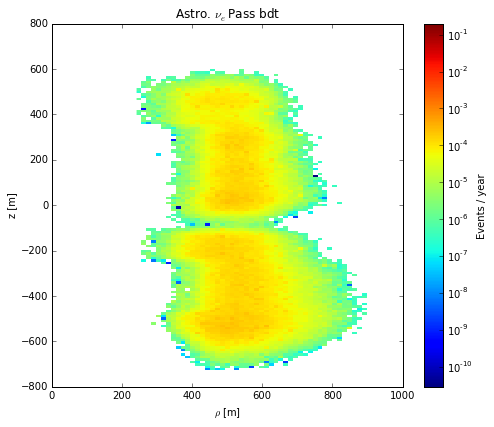

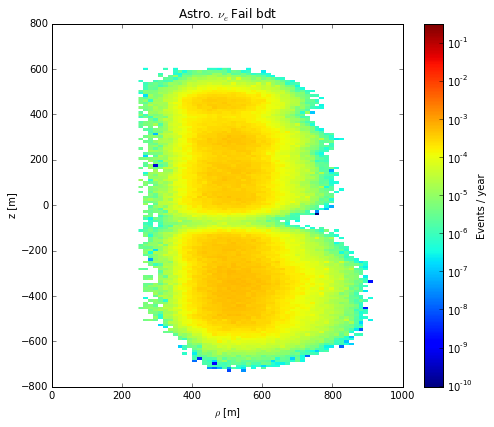

In [75]:
# Ok let's dig into some 2D distributions to see if we are 
# really getting what we are after.
from PlotTool import PlotTool
pt = PlotTool()

for i in range(len(info['data'])):
    dt = info['data'][i]
    name = info['names'][i]
    sname = info['snames'][i]
    
    plt.figure(figsize=(7,6))
    pt.ploth2(np.sqrt(np.power(dt.eVtxX,2)+np.power(dt.eVtxY,2)).as_matrix(),
              dt.eVtxZ.as_matrix(),
              dt.wE2.as_matrix(),
              r'$\rho$ [m]','z [m]','Events / year',
              (1000,1000),0,1000,-800,800,-1,-1,False)
    cb = plt.colorbar()
    cb.set_label('Events / year')
    plt.title(name)
    plt.tight_layout()
    plt.savefig(savedir+'rho_z_'+sname+'.png')
    

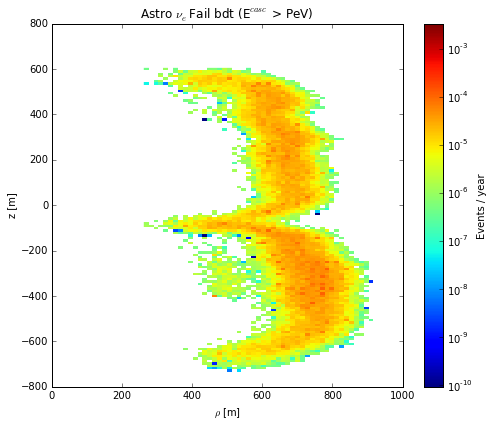

In [95]:
# What about those high energy cascades that fail the bdt?
dt = nue_f[ (np.log10(nue_f.eE+nue_f.hE)) >= 6 ]
plt.figure(figsize=(7,6))
pt.ploth2(np.sqrt(np.power(dt.eVtxX,2)+np.power(dt.eVtxY,2)).as_matrix(),
              dt.eVtxZ.as_matrix(),
              dt.wE2.as_matrix(),
              r'$\rho$ [m]','z [m]','Events / year',
              (1000,1000),0,1000,-800,800,-1,-1,False)
cb = plt.colorbar()
cb.set_label('Events / year')
plt.title(r'Astro $\nu_{e}$ Fail bdt (E$^{casc}$ > PeV)')
plt.tight_layout()
plt.savefig(savedir+'rho_z_failed_CascadeE_PeV.png')



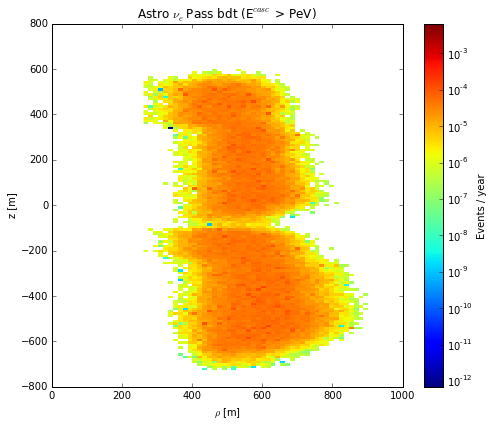

In [94]:
# What about those high energy cascades that fail the bdt?
dt = nue_p[ (np.log10(nue_p.eE+nue_p.hE)) >= 6 ]
plt.figure(figsize=(7,6))
pt.ploth2(np.sqrt(np.power(dt.eVtxX,2)+np.power(dt.eVtxY,2)).as_matrix(),
              dt.eVtxZ.as_matrix(),
              dt.wE2.as_matrix(),
              r'$\rho$ [m]','z [m]','Events / year',
              (1000,1000),0,1000,-800,800,-1,-1,False)
cb = plt.colorbar()
cb.set_label('Events / year')
plt.title(r'Astro $\nu_{e}$ Pass bdt (E$^{casc}$ > PeV)')
plt.tight_layout()
plt.savefig(savedir+'rho_z_passed_CascadeE_PeV.png')



In [96]:
# Add maxdist
nue_p['maxDist'] = maxDistMaxDoms(nue_p)
nue_f['maxDist'] = maxDistMaxDoms(nue_f)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [99]:
# Now plot most of the BDT variables
# Plot also some reco variables
variables = {'hs_z_travel' : [50,-500,500, 'ztravel','z-travel [m]'],
             #'rho_travel'  : [50, 0, 1000, 'rhotravel', r'$\rho$-travel [m]'],
             'log10(hs_q_tot_pulses)' : [40, 3, 7, 'logqtot','log10(NPE)'],
             #'log10(NPE)'     : [40, 3, 7, 'lognpe','log10(NPE) (portia)'],
             #'qratio'         : [100,0,1,'qratio','qratio'],
             #'hm_nhit_doms'   : [50,0,1500, 'hitdoms', r'N Hit Doms'],
             #'hm_nhit_strings': [60,0,60,'hitstrings','N Hit Strings'],
             #'Nch'            : [50,0,1500, 'Nch', 'N Channel (portia)'],
             #'tlarge5[0]-tearly5[0]'  : [100, 0, 10000, 'tEarlyMinusLarge', 'tlarge-tearly'],
             'cumuAt600ns' : [25,0,1,'cumuAt600ns','Cumulative @ 600ns'],
             'maxDist' : [25,0,1000,'maxDist','Max Dist 3 Largest Charge DOms'],
             'ImpLF_rchi2' : [50,0,500,'rchi2',r'Reduced $\chi^{2}$'],
             'hs_cogz' : [50,-500,500,'cog_z','COG z [m]'],
             'sqrt(hs_cogx*hs_cogx+hs_cogy*hs_cogy)' : [30,0,600,'cog_rho',r'COG $\rho$'],
             #'bQRat' : [50,1,25,'balloonQRatio_zoom',r'NPE$^{tot}$ / NPE$^{MaxDom}$ (zoomed)'],
             'rho_travel5' : [50,0,1000,'rhotravel5pe',r'$\rho$-travel (> 5 p.e.) [m]'],
             'ndoms_5pe' : [50,0,500,'hitdoms5pe','N Hit Doms (> 5 p.e.)'],
             'nstr_2ndway_5pe' : [60,0,60,'nstr_2ndway_5pe','N Hit Strings (> 5 p.e.)']
            }


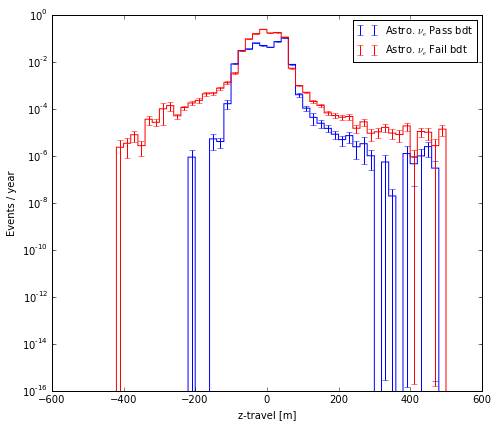

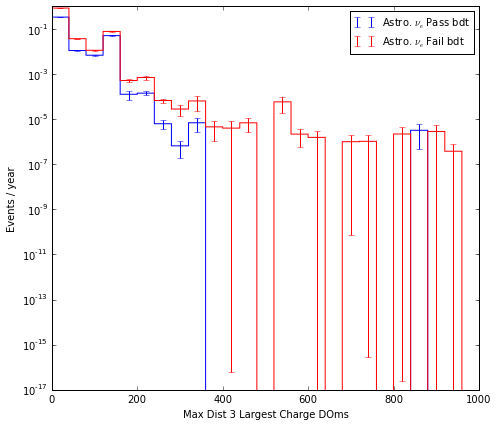

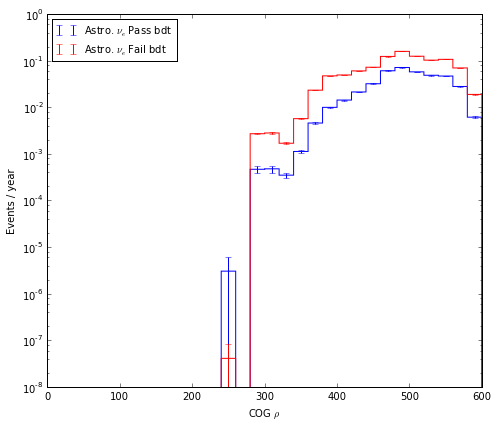

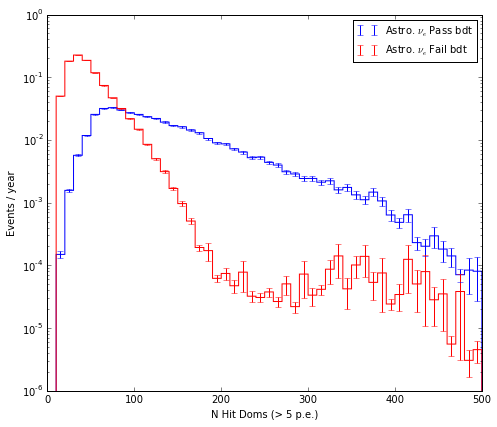

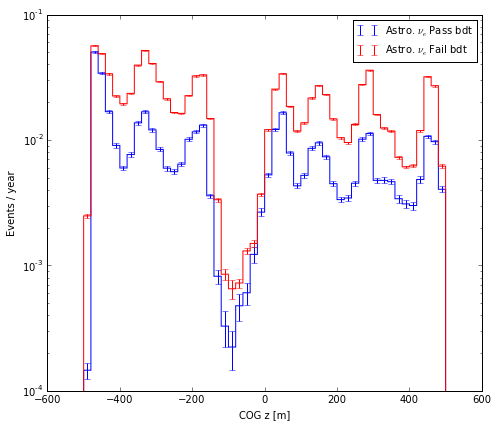

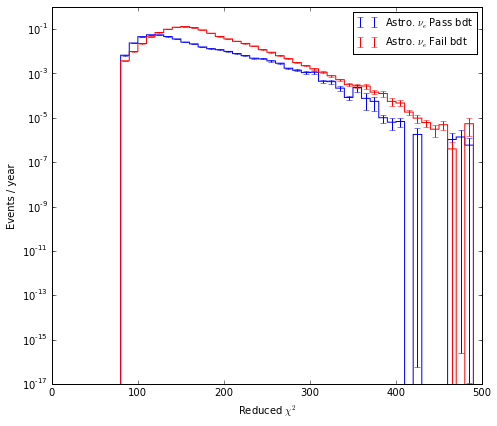

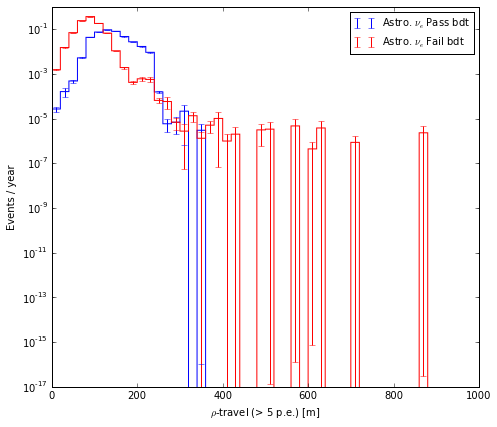

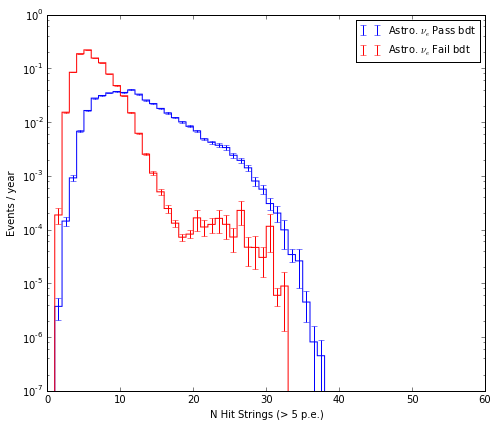

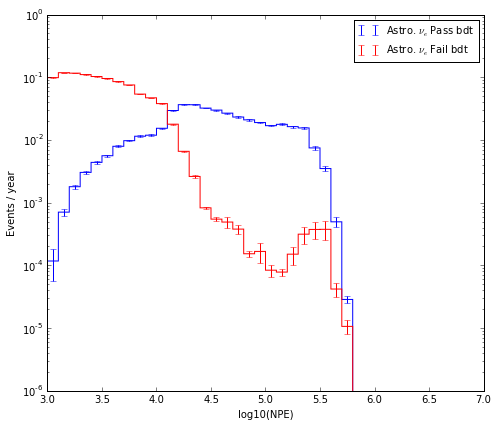

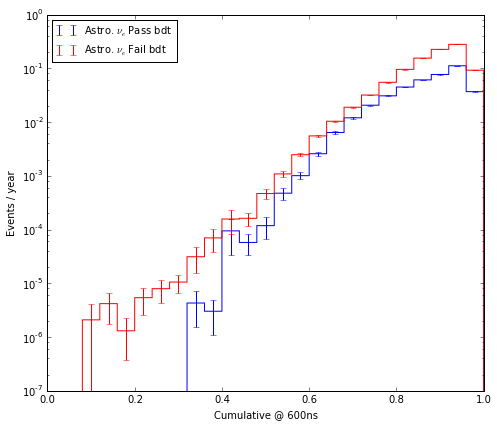

In [101]:
for var in variables:
    opts = variables[var]

    fig,ax = plt.subplots(ncols=1,figsize=(7,6))

    for i in range(len(info['data'])):
        dt = info['data'][i]
        name = info['names'][i]
        c = info['c'][i]
    
        plt.hist(dt[var].as_matrix(),
                 weights=dt.wE2.as_matrix(),
                 histtype='step',
                 bins=opts[0],range=(opts[1],opts[2]),
                 color=c)
        bc, be, center = pt.plotErrorBars(dt[var].as_matrix(),
                                      dt.wE2.as_matrix(), 
                                      opts[0],opts[1],opts[2],
                                      c,name,' ')
    
    ax.set_yscale('log')
    plt.xlabel(opts[4])
    plt.ylabel('Events / year')
    plt.legend(loc='best',fontsize='medium')
    plt.tight_layout()
    plt.savefig(savedir+'BDTVar_PassFailComp_'+opts[3]+'.png')